# **Exploratory Data Analysis**



## **1. Project Setup**

#### 1.1 Import Libraries

In [2]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from lcz_classification.config import *
from lcz_classification.util import read_lcz_legend, normalize_arr, jeffries_matuista_distance, band_stats
from lcz_classification.plots import plot_spectral_signature, pairwise_plot

from shapely.geometry import box
import geopandas as gpd
from rasterstats import zonal_stats
import rioxarray as rio
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt




#### 1.2. Setup Paths

In [3]:
## WORFLOW PARAMETERS

## USER INPUT ##
# ===============================================================================================================================================================


S2_FILE_PATH=f"../data/processed/sentinel2/resampled/s2_20210714_30m.tif"


## PROJECT CONFIGURATION ##
# ===============================================================================================================================================================


# Establish Study Area bounds
STUDY_AREA_GDF=gpd.read_file(f"{STUDY_AREA}/study_area.geojson")
STUDY_AREA_GDF=STUDY_AREA_GDF.to_crs(STUDY_AREA_GDF.estimate_utm_crs())

# Create Bounding Box Polygon
BBOX=box(*list(STUDY_AREA_GDF.total_bounds))
BBOX= BBOX.buffer(15, join_style=2) # Create 15 meter buffer for bounding box

# Retrieve CRS Based on bounds of study area
CRS=STUDY_AREA_GDF.estimate_utm_crs() # NAD83 / UTM zone 9N


LCZ_LEGEND, COLOR_DICT=read_lcz_legend(LCZ_LEGEND_FP)
label_dict=LCZ_LEGEND.set_index("class")["name"].to_dict()

lcz_gdf=gpd.read_file(LCZ_TRAINING_FP)
lcz_gdf.geometry=lcz_gdf.geometry.buffer(-1).buffer(1)

# lcz_gdf["Class ID"]=lcz_gdf.Class.apply(lambda x: x)

# lcz_gdf=lcz_gdf[lcz_gdf.Name.apply(lambda x: len(x) < 4)].reset_index(drop=True)
lcz_gdf["Class ID"] = lcz_gdf.Class.apply(lambda cl: LCZ_LEGEND.set_index("class").loc[cl]["class_id"])
lcz_gdf["Name"] = lcz_gdf.Class.apply(lambda cl: LCZ_LEGEND.set_index("class").loc[cl]["name"])
# lcz_gdf["Class"] = lcz_gdf["Class ID"].apply(lambda cl: lcz_legend.set_index("class_id").loc[cl]["class"])
colors=lcz_gdf.Class.apply(lambda cl: LCZ_LEGEND.set_index("class").loc[cl].hex)
lcz_gdf.dropna(subset=["geometry"], inplace=True)


S2A_BANDS=S2_BANDS[S2_BANDS.mission == "S2A"]
# Select Sentinel-2 Bands
SENT2_BANDS=["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"] #Sentinel-2, bands from B02 to B07, B8A, B11, and B12 (provided at 20 m spatial resolution by Copernicus) are exploited.



#### 1.3. Load Data

In [4]:
s2=rio.open_rasterio(S2_FILE_PATH)

s2['band'] = SENT2_BANDS
s2 = s2 / 10000
## URBAN CANOPY PARAMETERS ##

bh=rio.open_rasterio(BH_FP) # Building Height
ch=rio.open_rasterio(CH_FP) # Tree Canopy Height
isf=rio.open_rasterio(IS_FP) # Impervious Surface Fraction
bsf=rio.open_rasterio(BS_FP) # Building Surface Fraction
svf=rio.open_rasterio(SF_FP) # Sky View Factor
lcz=rio.open_rasterio(LCZ_FP) # Local Climate Zones Rasterized (Class Layer)

features=SENT2_BANDS
features.extend(['Building Height', 'Canopy Height', 'Impervious Surface Fraction', 'Building Surface Fraction'])


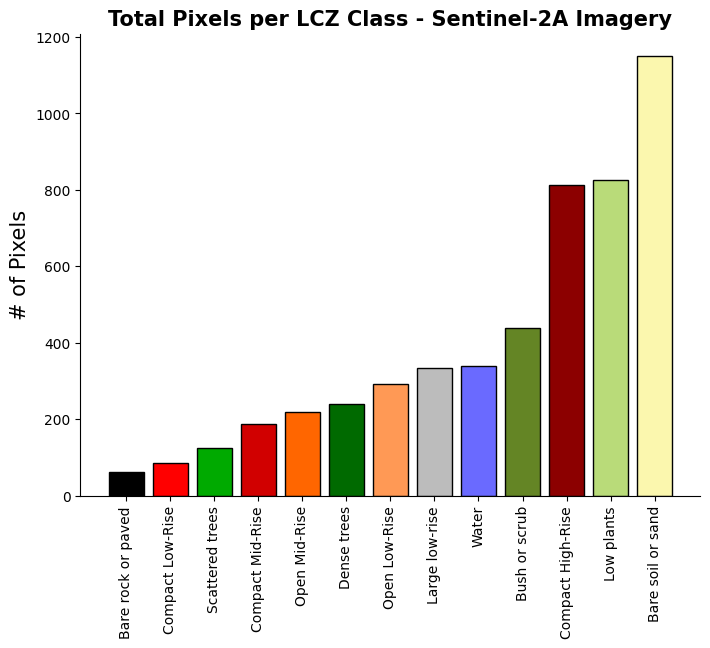

In [4]:
lcz_values=lcz.values.reshape(-1)
lcz_values=lcz_values[lcz_values > 0]
lcz_values_df=pd.DataFrame(lcz_values, columns = ["Class"])
lcz_label_counts=lcz_values_df.value_counts().reset_index().sort_values("count")
lcz_label_counts["label"] = [label_dict[x] for x in np.int16(lcz_label_counts.Class)]
colors=[LCZ_LEGEND.set_index('class').loc[x].hex for x in lcz_label_counts.Class]

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x=lcz_label_counts.label,height=lcz_label_counts['count'], color=colors, linewidth=1, edgecolor='black')

plt.xticks(rotation=90)
plt.ylabel('# of Pixels', fontdict=dict(size=15))
plt.title('Total Pixels per LCZ Class - Sentinel-2A Imagery', fontdict=dict(size=15,weight='bold'))
 # Hide specific spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## **2. Spectral Signatures of LCZs Sentinel-2**

#### 2.1 Calculate Band Statistics of LCZ Training Samples from Sentinel-2 Imagery

In [5]:
# Retrieve MultiPolygons of each LCZ Class
zones=lcz_gdf.dissolve(by="Name")

# Use LCZ MultiPolygons to Computer Sentinel-2 band statistics for each LCZ 
band_stats_df=band_stats(zones,s2)

# Map S2A wavelengths in nanometers (nm) to band names for plotting
s2a_wl_dict=S2A_BANDS.set_index('band').wavelength_nm.to_dict()
band_stats_df['wavelength_nm'] = band_stats_df.band.apply(lambda x: s2a_wl_dict[x])
band_stats_df=band_stats_df.set_index('Name').join(LCZ_LEGEND.set_index('name')).reset_index()

#### 2.1 Plot LCZ Spectral Signatures

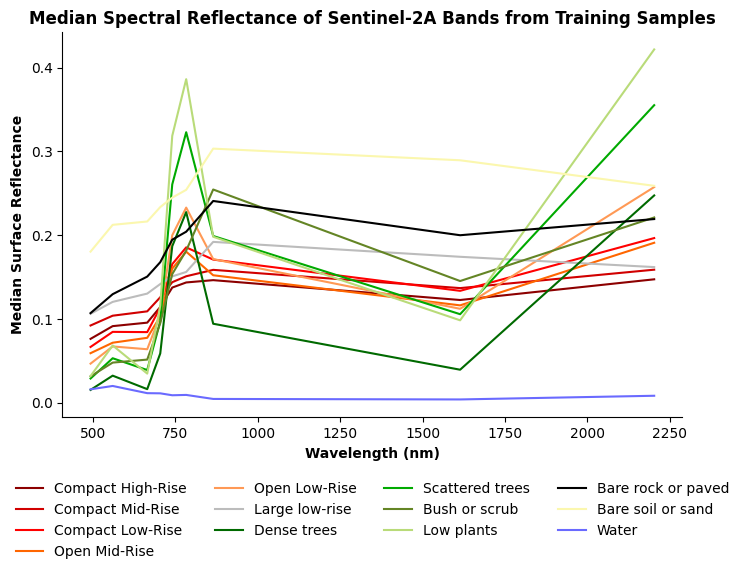

In [6]:

plot_spectral_signature(
    band_stats=band_stats_df,
    x_col='wavelength_nm',
    class_col='Name',
    color_dict=COLOR_DICT,
    title = "Median Spectral Reflectance of Sentinel-2A Bands from Training Samples",
    xlabel= "Wavelength (nm)",
    stat='median'
)

## **3. Jeffries-Matuista Distance of LCZ Training Areas**

#### 3.1. Compute Jeffries-Matuista Distance Sentinel-2 Imagery

In [7]:
classes=band_stats_df.reset_index().Name.unique()

X_clipped=[s2.rio.clip([zones.loc[class_name].geometry], crs=zones.crs,drop=True).values for class_name in classes]

X_clipped=[X.reshape(-1, X.shape[0]) for X in X_clipped]
X_clipped=[X[~np.isnan(X).any(axis=1)] for X in X_clipped] 
X_dict=dict(zip(classes,X_clipped))

class_pairs=[[cl1,cl2] for cl2 in classes for cl1 in classes]

jm_list=list()

for pair in class_pairs:
    f1, f2 = pair
    x = X_dict[f1]
    y = X_dict[f2]
    jm_list.append(jeffries_matuista_distance(x,y))



class1 = [p[0] for p in class_pairs]
class2 = [p[1] for p in class_pairs]

df=pd.DataFrame(dict(
    class1=class1,
    class2=class2,
    jm=jm_list
))




#### 3.1. Plot Jeffries-Matuista Distance Matrix from Sentinel-2 Imagery

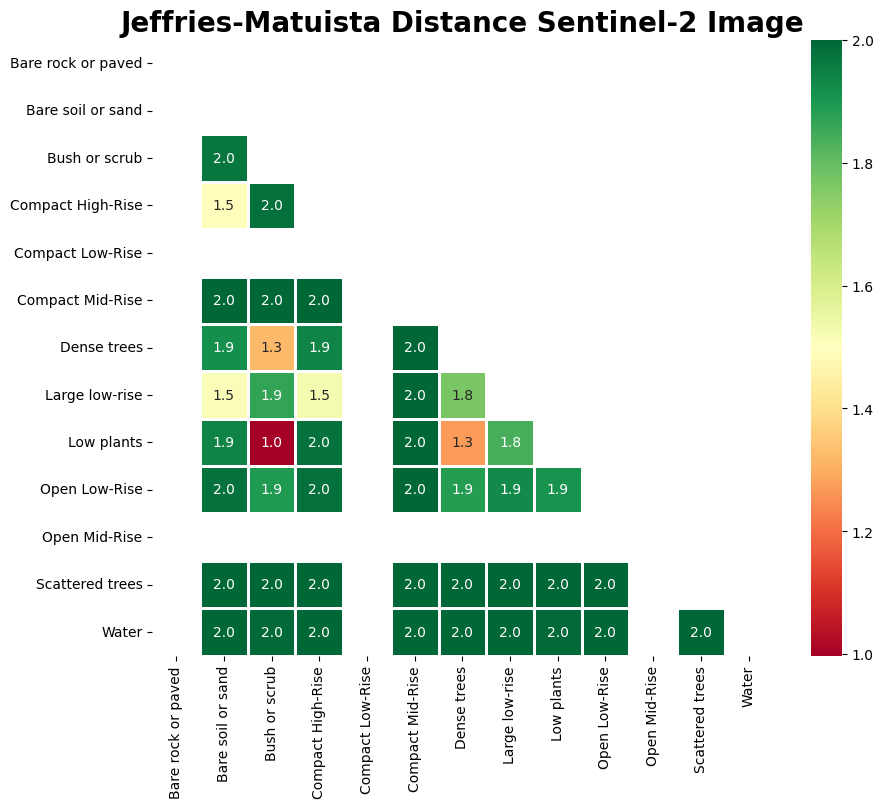

In [8]:

pairwise_plot(df=df,
              class1='class1',
              class2='class2',
              dist_col='jm',
              title='Jeffries-Matuista Distance Sentinel-2 Image'
              )

## 3. Plot Urban Canopy Parameters

Building Height
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Canopy Height
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Impervious Surface Fraction
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Building Surface Fraction
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Sky View Factor
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


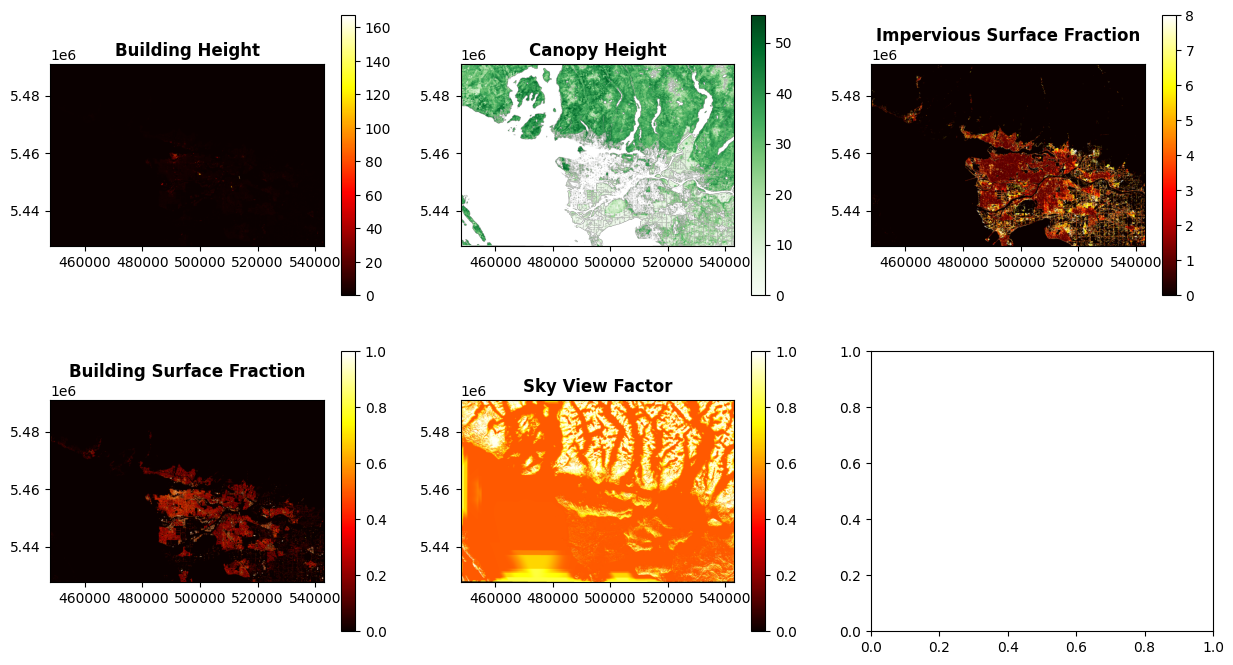

In [ ]:

import rasterio as r
from rasterio.plot import show
fig, axs = plt.subplots(2,3, figsize=(15,8))

files=UCPS.copy()
files.append(None)

idx=0
titles=['Building Height', 'Canopy Height', 'Impervious Surface Fraction', 'Building Surface Fraction', 'Sky View Factor']
cmaps=['hot', 'Greens', 'hot', 'hot', 'hot']
for row in axs:
    for col in row:
        if files[idx] is not None:
            # print(titles[idx])
            image=r.open(files[idx])
            print(image.read(1))
            img=show(image.read(1),ax=col, transform= image.transform, cmap=cmaps[idx], title=titles[idx])
            cbar = plt.colorbar(img.get_images()[0], ax=col)
            idx+=1

plt.show()